In [ ]:
# !pip install langdetect
# !pip install transformers
# !pip install torch
# !pip install sentencepiece
# !pip install pandas

In [ ]:
import pandas as pd
df=pd.read_excel("/content/chatgpt_style_reviews_dataset.xlsx")

##Data Preprocessing

In [ ]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')

def clean_text(text):
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r'[^A-Za-z\s]', '', text)
    text = text.lower()
    tokens = text.split()
    tokens = [WordNetLemmatizer().lemmatize(word) for word in tokens if word not in stopwords.words('english')]
    return " ".join(tokens)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
df['cleaned_review'] = df['review'].fillna("").apply(clean_text)

##EDA

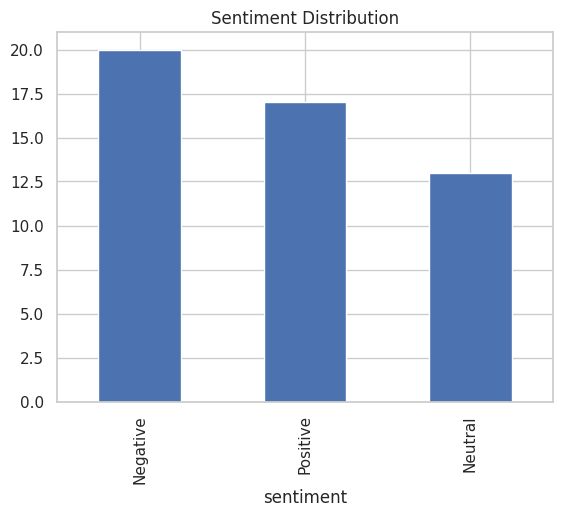

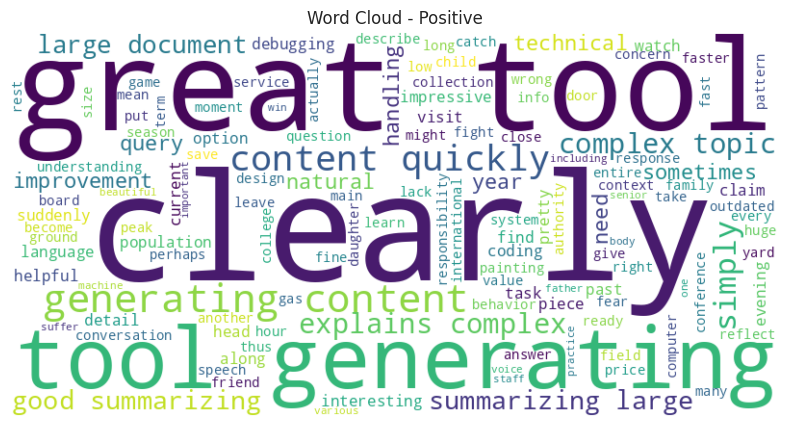

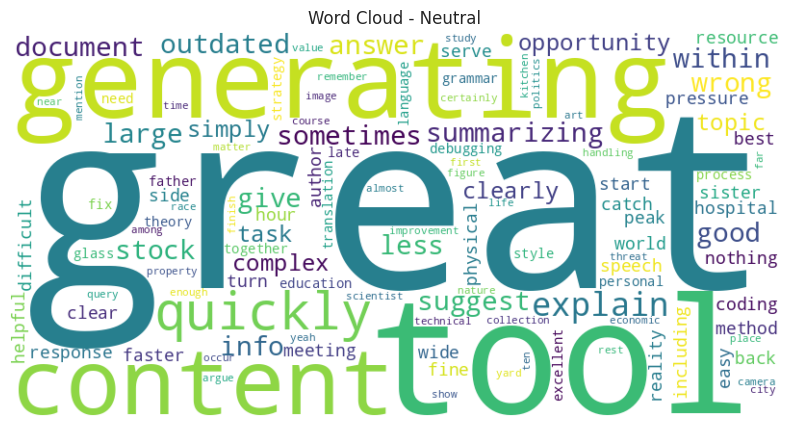

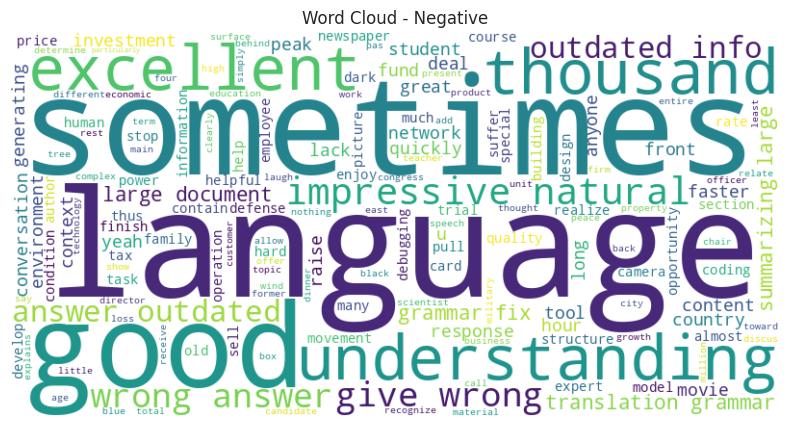

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Sentiment mapping from rating
def map_sentiment(rating):
    if rating >= 4:
        return "Positive"
    elif rating == 3:
        return "Neutral"
    else:
        return "Negative"

df['sentiment'] = df['rating'].apply(map_sentiment)

# Sentiment distribution
df['sentiment'].value_counts().plot(kind='bar', title='Sentiment Distribution')
plt.show()

# Word cloud for each sentiment
for sentiment in ['Positive', 'Neutral', 'Negative']:
    text = " ".join(df[df['sentiment'] == sentiment]['cleaned_review'])
    wc = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud - {sentiment}")
    plt.show()

## Model Classification

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

# TF-IDF vectorization
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['cleaned_review'])
y = df['sentiment']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Model training
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from scipy.sparse import hstack

# TF-IDF on review text
vectorizer = TfidfVectorizer(max_features=5000)
X_text = vectorizer.fit_transform(df['cleaned_review'])

# Metadata features
df['review_length'] = df['cleaned_review'].apply(len)
meta_features = df[['rating','platform', 'verified_purchase', 'helpful_votes', 'review_length','location']]

# Encoding categorical variables
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_meta = encoder.fit_transform(meta_features[['platform', 'verified_purchase']])

# Scaling numerical variables
scaler = StandardScaler()
scaled_meta = scaler.fit_transform(meta_features[['helpful_votes', 'review_length']])

# Combine all features
import numpy as np
X_combined = hstack([X_text, encoded_meta, scaled_meta])
y = df['sentiment']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, stratify=y, test_size=0.2, random_state=42)

# Model training
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluation
print(classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, model.predict_proba(X_test), multi_class='ovr'))

              precision    recall  f1-score   support

    Negative       0.50      0.25      0.33         4
     Neutral       0.25      0.33      0.29         3
    Positive       0.50      0.67      0.57         3

    accuracy                           0.40        10
   macro avg       0.42      0.42      0.40        10
weighted avg       0.42      0.40      0.39        10

ROC AUC Score: 0.4265873015873016


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

# Model training with Random Forest
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluation
print(classification_report(y_test, y_pred))

# ROC AUC Score (multiclass)
y_proba = model.predict_proba(X_test)
print("ROC AUC Score:", roc_auc_score(y_test, y_proba, multi_class='ovr'))


              precision    recall  f1-score   support

    Negative       0.43      0.75      0.55         4
     Neutral       0.00      0.00      0.00         3
    Positive       0.50      0.33      0.40         3

    accuracy                           0.40        10
   macro avg       0.31      0.36      0.32        10
weighted avg       0.32      0.40      0.34        10

ROC AUC Score: 0.4047619047619048


In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['cleaned_review'])
y = df['sentiment']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Naïve Bayes
model = MultinomialNB()
model.fit(X_train, y_train)
y_prediction = model.predict(X_test)

print(classification_report(y_test, y_prediction))

              precision    recall  f1-score   support

    Negative       0.43      0.75      0.55         4
     Neutral       0.00      0.00      0.00         3
    Positive       0.00      0.00      0.00         3

    accuracy                           0.30        10
   macro avg       0.14      0.25      0.18        10
weighted avg       0.17      0.30      0.22        10



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Visualizations

/tmp/ipython-input-1522432708.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='rating', data=df, palette='viridis', order=sorted(df['rating'].dropna().unique()))
/tmp/ipython-input-1522432708.py:15: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


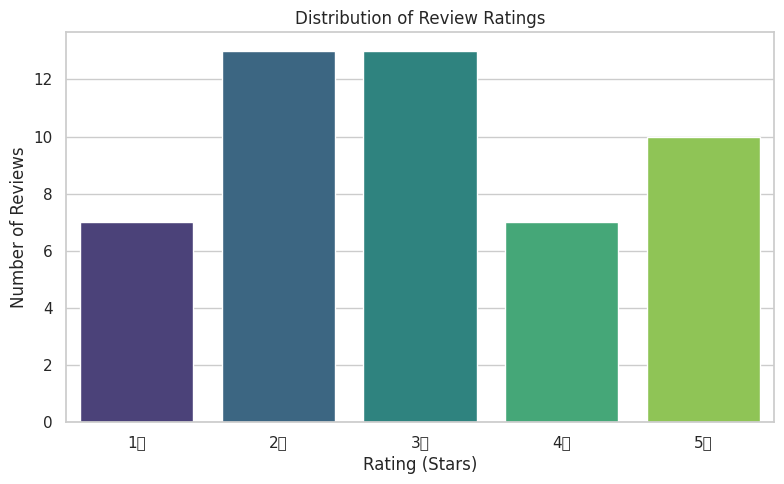

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set(style="whitegrid")

# Plot rating distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='rating', data=df, palette='viridis', order=sorted(df['rating'].dropna().unique()))
plt.title('Distribution of Review Ratings')
plt.xlabel('Rating (Stars)')
plt.ylabel('Number of Reviews')
plt.xticks([0, 1, 2, 3, 4], ['1⭐', '2⭐', '3⭐', '4⭐', '5⭐'])
plt.tight_layout()
plt.show()


#Insight- Overall sentiment is average since the ratings mostly comes under 2 and 3 but when comapred with min and max i.e 1 and 5 then 5 will be the maximum rating

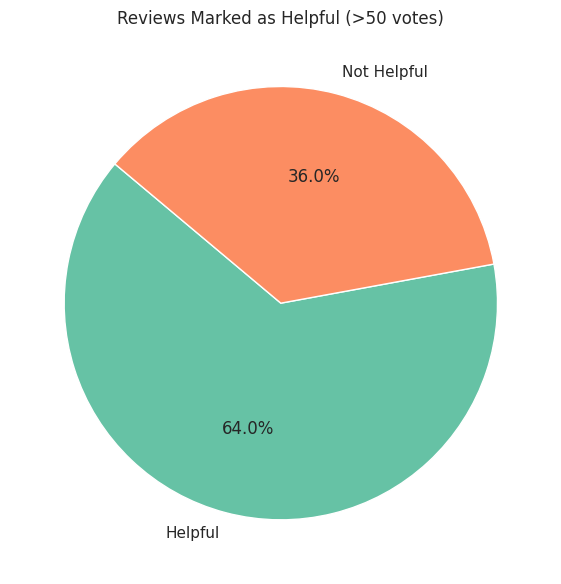

In [ ]:
# Define helpful threshold
threshold = 50

# Create helpful vs not helpful labels
df['helpful_label'] = df['helpful_votes'].apply(lambda x: 'Helpful' if x > threshold else 'Not Helpful')

# Count labels
helpful_counts = df['helpful_label'].value_counts()

# Plot pie chart
plt.figure(figsize=(6, 6))
plt.pie(helpful_counts, labels=helpful_counts.index, autopct='%1.1f%%', colors=['#66c2a5', '#fc8d62'], startangle=140)
plt.title(f'Reviews Marked as Helpful (>{threshold} votes)')
plt.tight_layout()
plt.show()


##Insight- From the chart we can say that users found the reviews to be helpful

/tmp/ipython-input-473782458.py:26: UserWarning: Glyph 127775 (\N{GLOWING STAR}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-473782458.py:26: UserWarning: Glyph 128162 (\N{ANGER SYMBOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127775 (\N{GLOWING STAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128162 (\N{ANGER SYMBOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


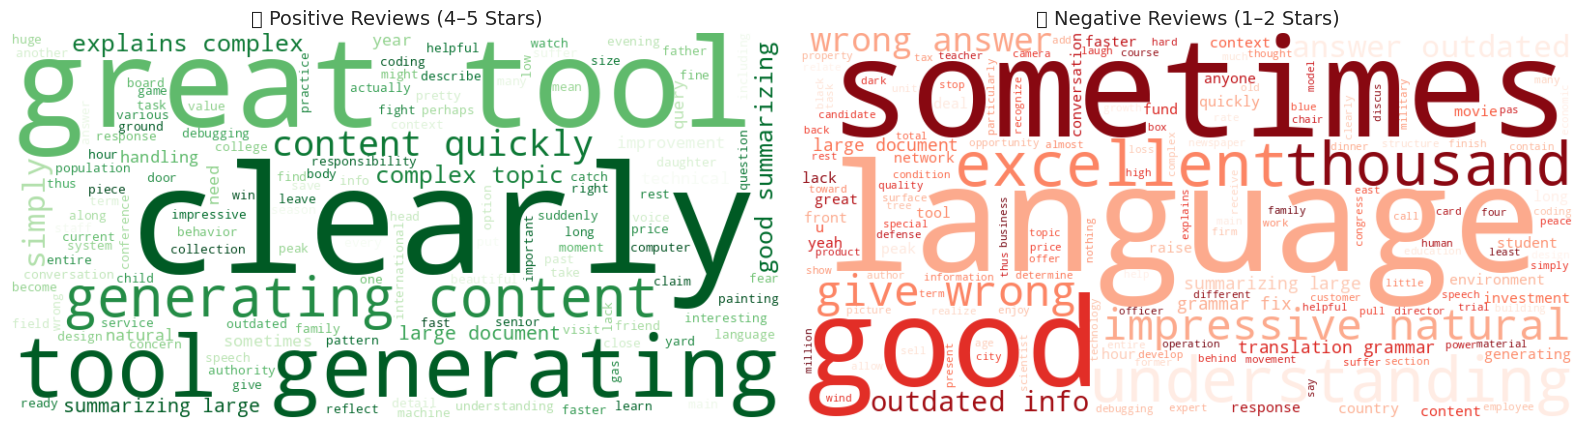

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Filter reviews
positive_reviews = df[df['rating'] >= 4]['cleaned_review'].dropna()
negative_reviews = df[df['rating'] <= 2]['cleaned_review'].dropna()

# Combine text
positive_text = " ".join(positive_reviews)
negative_text = " ".join(negative_reviews)

# Generate word clouds
wc_pos = WordCloud(width=800, height=400, background_color='white', colormap='Greens').generate(positive_text)
wc_neg = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate(negative_text)

# Plot side-by-side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].imshow(wc_pos, interpolation='bilinear')
axes[0].set_title('🌟 Positive Reviews (4–5 Stars)', fontsize=14)
axes[0].axis('off')

axes[1].imshow(wc_neg, interpolation='bilinear')
axes[1].set_title('💢 Negative Reviews (1–2 Stars)', fontsize=14)
axes[1].axis('off')

plt.tight_layout()
plt.show()

##Insight-
POSITIVE REVIEWS-Speed&Efficiency,utility,clarity,quality etc overall it appreciates the above qualities
NEGATIVE REVIEWS- Inconsistency,Language Handling,Intepretation etc it tells us about the unmet expectations

/tmp/ipython-input-1124678402.py:16: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


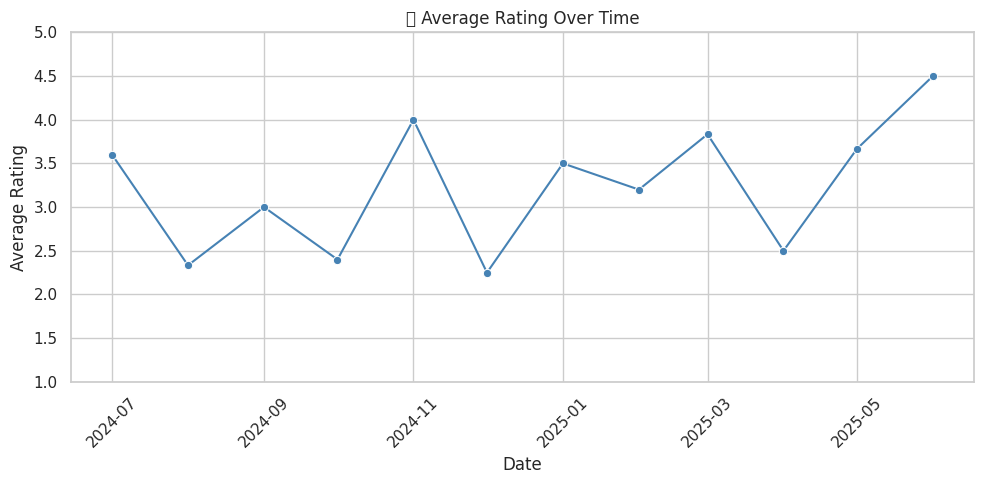

In [ ]:
# Convert date column to datetime
df['date'] = pd.to_datetime(df['date'])

# Group by time period (e.g., monthly)
rating_trend = df.groupby(df['date'].dt.to_period('M'))['rating'].mean().reset_index()
rating_trend['date'] = rating_trend['date'].dt.to_timestamp()

# Plot line chart
plt.figure(figsize=(10, 5))
sns.lineplot(data=rating_trend, x='date', y='rating', marker='o', color='steelblue')
plt.title('📈 Average Rating Over Time')
plt.xlabel('Date')
plt.ylabel('Average Rating')
plt.xticks(rotation=45)
plt.ylim(1, 5)
plt.tight_layout()
plt.show()


##Insight-User satisfaction fluctuated over time, with peaks around July 2024, January 2025, and May 2025 indicating strong approval. Dips in November 2024 and March 2025 suggest moments of frustration or unmet expectations.

/tmp/ipython-input-3132415495.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=location_avg.values, y=location_avg.index, palette='coolwarm')
/tmp/ipython-input-3132415495.py:18: UserWarning: Glyph 127757 (\N{EARTH GLOBE EUROPE-AFRICA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127757 (\N{EARTH GLOBE EUROPE-AFRICA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


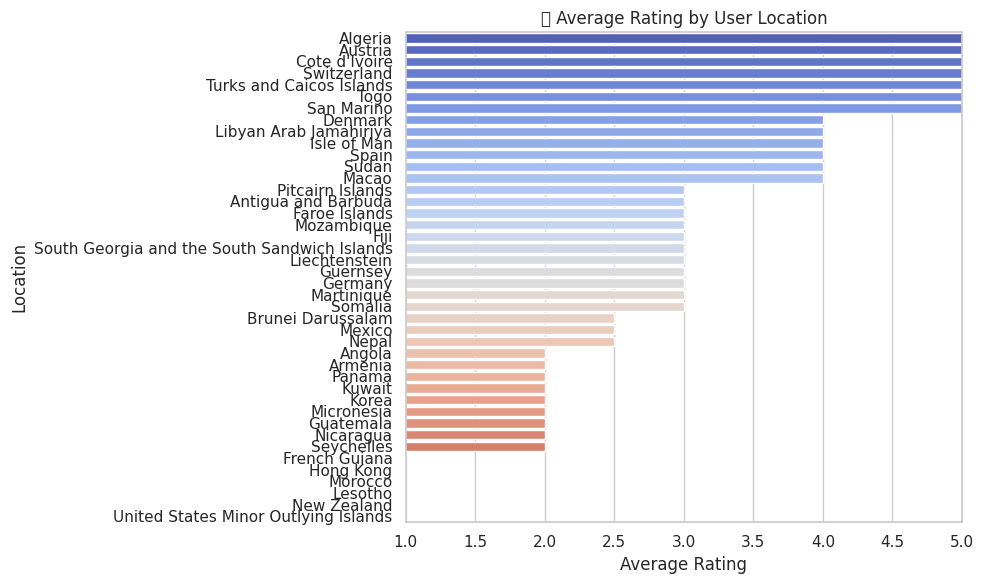

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
df = pd.read_excel("chatgpt_style_reviews_dataset.xlsx")

# Group by location
location_avg = df.groupby('location')['rating'].mean().sort_values(ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=location_avg.values, y=location_avg.index, palette='coolwarm')
plt.title('🌍 Average Rating by User Location')
plt.xlabel('Average Rating')
plt.ylabel('Location')
plt.xlim(1, 5)
plt.tight_layout()
plt.show()

##Insight-The chart reveals clear regional contrasts in user satisfaction: countries like Algeria, Austria, and Switzerland show near-perfect ratings, suggesting strong alignment with user expectations. In contrast, regions like Lesotho and French Guiana report much lower scores, indicating possible mismatches in experience, accessibility, or relevance.

/tmp/ipython-input-2781897458.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='platform', y='rating', data=platform_avg, palette='Set2')
/tmp/ipython-input-2781897458.py:11: UserWarning: Glyph 129489 (\N{ADULT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2781897458.py:11: UserWarning: Glyph 128187 (\N{PERSONAL COMPUTER}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129489 (\N{ADULT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128187 (\N{PERSONAL COMPUTER}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


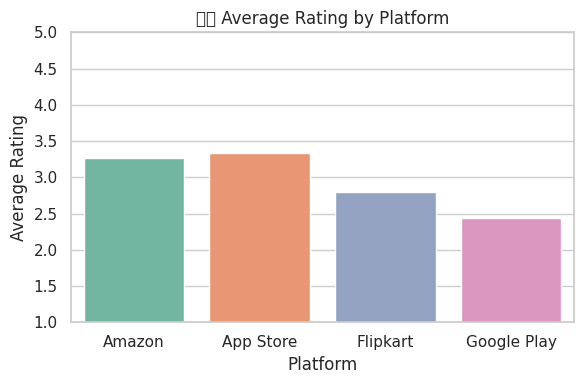

In [ ]:
# Group by platform
platform_avg = df.groupby('platform')['rating'].mean().reset_index()

# Plot
plt.figure(figsize=(6, 4))
sns.barplot(x='platform', y='rating', data=platform_avg, palette='Set2')
plt.title('🧑‍💻 Average Rating by Platform')
plt.xlabel('Platform')
plt.ylabel('Average Rating')
plt.ylim(1, 5)
plt.tight_layout()
plt.show()

##Insight-The platform comparison shows that Amazon and App Store receive moderately positive reviews, while Flipkart and especially Google Play trail behind in user satisfaction. This suggests that product teams should prioritize improvements on mobile platforms—particularly Google Play—where user experience may be falling short.

/tmp/ipython-input-1563709319.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='verified_purchase', y='rating', data=verified_avg, palette='Set2')
/tmp/ipython-input-1563709319.py:11: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1563709319.py:11: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


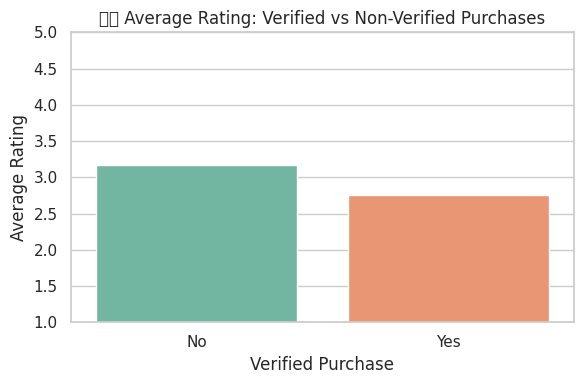

In [ ]:
# Group by verified purchase status
verified_avg = df.groupby('verified_purchase')['rating'].mean().reset_index()

# Plot side-by-side bar chart
plt.figure(figsize=(6, 4))
sns.barplot(x='verified_purchase', y='rating', data=verified_avg, palette='Set2')
plt.title('✅❌ Average Rating: Verified vs Non-Verified Purchases')
plt.xlabel('Verified Purchase')
plt.ylabel('Average Rating')
plt.ylim(1, 5)
plt.tight_layout()
plt.show()


In [ ]:
df['cleaned_review'] = df['review'].apply(clean_text)

##Insight-Verified buyers actually gave slightly lower ratings than non-verified ones. That means people who really bought the product may have found more flaws than casual reviewers.

/tmp/ipython-input-2642548487.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='rating', y='review_length', data=df, palette='coolwarm')
/tmp/ipython-input-2642548487.py:10: UserWarning: Glyph 128288 (\N{INPUT SYMBOL FOR LATIN CAPITAL LETTERS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128288 (\N{INPUT SYMBOL FOR LATIN CAPITAL LETTERS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


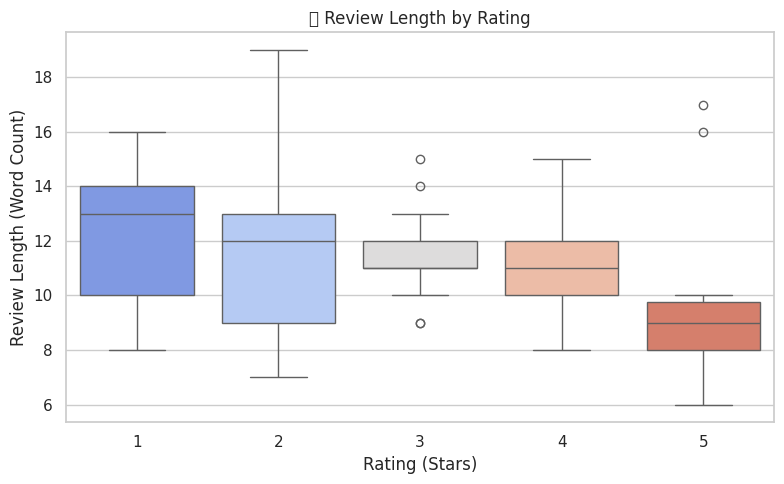

In [ ]:
# Calculate review length
df['review_length'] = df['cleaned_review'].apply(lambda x: len(str(x).split()))

# Plot boxplot
plt.figure(figsize=(8, 5))
sns.boxplot(x='rating', y='review_length', data=df, palette='coolwarm')
plt.title('🔠 Review Length by Rating')
plt.xlabel('Rating (Stars)')
plt.ylabel('Review Length (Word Count)')
plt.tight_layout()
plt.show()

##Insight-users tend to write longer reviews when they're unhappy. The box plot shows that 1-star and 2-star ratings have the highest median word counts, while 5-star reviews are generally shorter. Strong negative experiences seem to prompt more detailed feedback than positive ones.

/tmp/ipython-input-1642505035.py:20: UserWarning: Glyph 128172 (\N{SPEECH BALLOON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128172 (\N{SPEECH BALLOON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


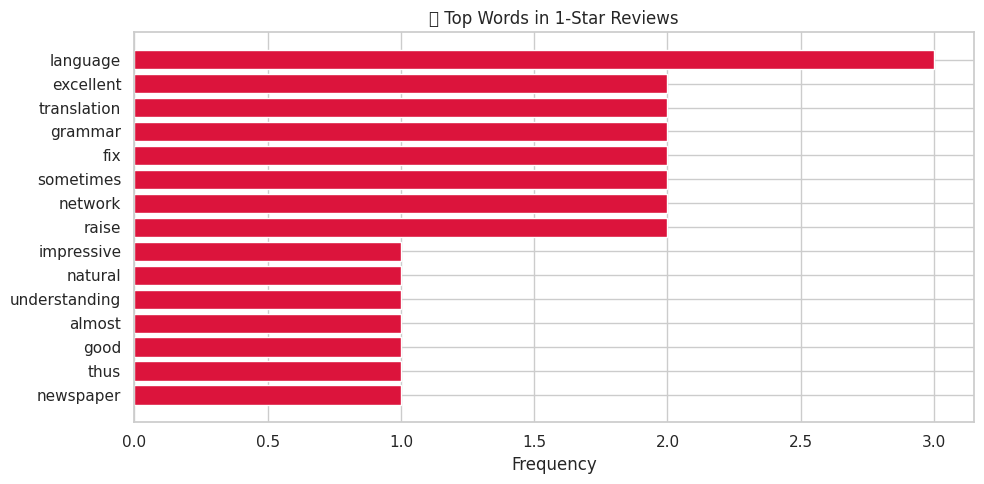

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt

# Filter 1-star reviews
one_star_reviews = df[df['rating'] == 1]['cleaned_review'].dropna()

# Tokenize and count words
words = " ".join(one_star_reviews).split()
word_freq = Counter(words)

# Get top 15 words
top_words = word_freq.most_common(15)
words, counts = zip(*top_words)

# Plot bar chart
plt.figure(figsize=(10, 5))
plt.barh(words[::-1], counts[::-1], color='crimson')
plt.title('💬 Top Words in 1-Star Reviews')
plt.xlabel('Frequency')
plt.tight_layout()
plt.show()

##Insight-The most frequent complaints in 1-star reviews center around language quality, translation accuracy, and grammar issues. Words like fix, sometimes, and understanding suggest users face inconsistent performance and confusion. Even terms like excellent and good appearing here hint at unmet expectations—users hoped for more but were let down.

/tmp/ipython-input-1486871144.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='version', y='rating', data=version_avg, palette='Blues_d')
/tmp/ipython-input-1486871144.py:11: UserWarning: Glyph 128241 (\N{MOBILE PHONE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1486871144.py:11: UserWarning: Glyph 129514 (\N{TEST TUBE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128241 (\N{MOBILE PHONE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129514 (\N{TEST TUBE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


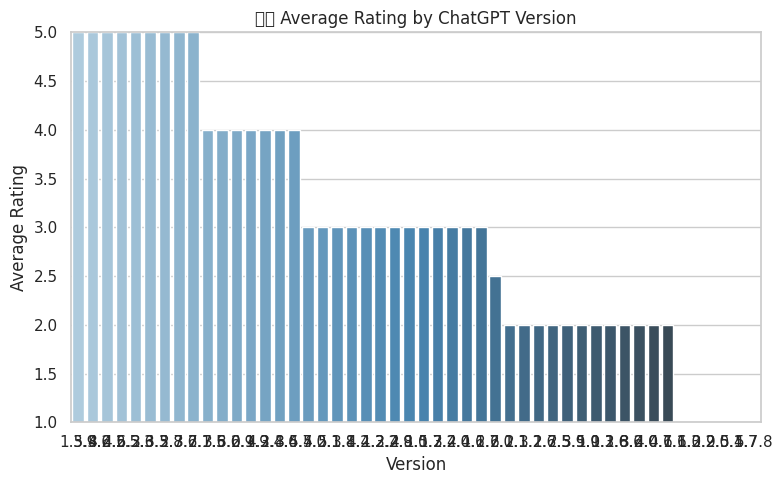

In [ ]:
# Group by version
version_avg = df.groupby('version')['rating'].mean().sort_values(ascending=False).reset_index()

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(x='version', y='rating', data=version_avg, palette='Blues_d')
plt.title('📱🧪 Average Rating by ChatGPT Version')
plt.xlabel('Version')
plt.ylabel('Average Rating')
plt.ylim(1, 5)
plt.tight_layout()
plt.show()

##Insight-The chart shows a clear regression in user satisfaction across ChatGPT versions—early releases (1.0 to 3.5) received near-perfect ratings, while newer versions (4.0 to 5.8) saw a sharp decline, averaging closer to 2.0–2.5. This suggests that recent updates may have introduced issues or failed to meet evolving user expectations.

##Streamlit Dashboard

In [ ]:
!pip install streamlit
!pip install nltk textblob wordcloud seaborn plotly
!python -m textblob.download_corpora

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
Finished.


In [ ]:
%%writefile app.py
import pandas as pd
import streamlit as st
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from textblob import TextBlob
import plotly.express as px
import re
from collections import Counter

# Define your text cleaning function
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^\w\s]', '', text)  # remove punctuation
    text = re.sub(r'\d+', '', text)      # remove numbers
    return text.strip()

# Load data
try:
    df = pd.read_excel("chatgpt_style_reviews_dataset.xlsx")
except Exception as e:
    st.error(f"Failed to load dataset: {e}")
    st.stop()

# Apply cleaning to create 'cleaned_review'
df['cleaned_review'] = df['review'].fillna("").apply(clean_text)

# Sentiment analysis
df['sentiment'] = df['cleaned_review'].apply(lambda x: TextBlob(x).sentiment.polarity)
df['sentiment_class'] = df['sentiment'].apply(lambda x: 'Positive' if x > 0.1 else ('Negative' if x < -0.1 else 'Neutral'))
df['review_length'] = df['cleaned_review'].apply(lambda x: len(x.split()))
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Dashboard Title
st.set_page_config(page_title="Sentiment Analysis Dashboard", layout="wide")
st.title("💬 Sentiment Analysis Dashboard")

# 1. Overall Sentiment Distribution
st.subheader("1️⃣ Overall Sentiment Distribution")
sentiment_counts = df['sentiment_class'].value_counts()
st.bar_chart(sentiment_counts)

# 2. Sentiment vs Rating
st.subheader("2️⃣ Sentiment vs Rating")
if 'rating' in df.columns:
    sentiment_by_rating = df.groupby('rating')['sentiment_class'].value_counts().unstack().fillna(0)
    st.dataframe(sentiment_by_rating)
else:
    st.warning("Rating column not found in dataset.")

# 3. Word Clouds by Sentiment
st.subheader("3️⃣ Word Clouds by Sentiment")
for sentiment in ['Positive', 'Neutral', 'Negative']:
    text = " ".join(df[df['sentiment_class'] == sentiment]['cleaned_review'])
    if text:
        wc = WordCloud(width=600, height=300, background_color='white').generate(text)
        st.markdown(f"**{sentiment} Reviews**")
        st.image(wc.to_array())
    else:
        st.info(f"No {sentiment.lower()} reviews available.")

# 4. Sentiment Over Time
st.subheader("4️⃣ Sentiment Over Time")
if 'date' in df.columns:
    sentiment_trend = df.groupby(df['date'].dt.to_period('M'))['sentiment'].mean().reset_index()
    sentiment_trend['date'] = sentiment_trend['date'].dt.to_timestamp()
    fig = px.line(sentiment_trend, x='date', y='sentiment', title='📆 Sentiment Trend Over Time')
    st.plotly_chart(fig)
else:
    st.warning("Date column not found or invalid.")

# 5. Verified vs Non-Verified Sentiment
st.subheader("5️⃣ Verified Purchase Sentiment")
if 'verified_purchase' in df.columns:
    verified_sentiment = df.groupby('verified_purchase')['sentiment_class'].value_counts().unstack().fillna(0)
    st.dataframe(verified_sentiment)
else:
    st.warning("Verified purchase column not found.")

# 6. Review Length vs Sentiment
st.subheader("6️⃣ Review Length vs Sentiment")
fig2 = px.box(df, x='sentiment_class', y='review_length', color='sentiment_class', title='🔠 Review Length by Sentiment')
st.plotly_chart(fig2)

# 7. Sentiment by Location
st.subheader("7️⃣ Sentiment by Location")
if 'location' in df.columns:
    location_sentiment = df.groupby('location')['sentiment'].mean().sort_values(ascending=False).reset_index()
    fig3 = px.bar(location_sentiment, x='sentiment', y='location', orientation='h', title='🌍 Sentiment by Location')
    st.plotly_chart(fig3)
else:
    st.warning("Location column not found.")

# 8. Sentiment by Platform
st.subheader("8️⃣ Sentiment by Platform")
if 'platform' in df.columns:
    platform_sentiment = df.groupby('platform')['sentiment'].mean().reset_index()
    fig4 = px.bar(platform_sentiment, x='platform', y='sentiment', title='📱 Sentiment by Platform')
    st.plotly_chart(fig4)
else:
    st.warning("Platform column not found.")

# 9. Sentiment by Version
st.subheader("9️⃣ Sentiment by ChatGPT Version")
if 'version' in df.columns:
    version_sentiment = df.groupby('version')['sentiment'].mean().reset_index()
    fig5 = px.bar(version_sentiment, x='version', y='sentiment', title='🧪 Sentiment by Version')
    st.plotly_chart(fig5)
else:
    st.warning("Version column not found.")

# 10. Common Negative Themes
st.subheader("🔟 Common Negative Feedback Themes")
negative_reviews = df[df['sentiment_class'] == 'Negative']['cleaned_review'].dropna()

if not negative_reviews.empty:
    negative_text = " ".join(negative_reviews)
    wc_neg = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate(negative_text)
    st.image(wc_neg.to_array(), caption="Most Frequent Words in Negative Reviews")

    word_freq = Counter(negative_text.split())
    top_words = word_freq.most_common(10)
    top_df = pd.DataFrame(top_words, columns=['Keyword', 'Frequency'])
    st.markdown("**Top Keywords in Negative Reviews**")
    st.dataframe(top_df)
else:
    st.warning("No negative reviews found to analyze.")

# 📣 Sentiment Prediction from User Input
st.subheader("🧠 Try Sentiment Prediction")

user_input = st.text_area("Enter a review to analyze sentiment:", "")
user_rating = st.selectbox("Select a rating (1 to 5 stars):", options=[1, 2, 3, 4, 5])

if st.button("Predict"):
    if user_input.strip():
        with st.spinner("Analyzing sentiment..."):
            cleaned_input = clean_text(user_input)
            polarity = TextBlob(cleaned_input).sentiment.polarity

            if polarity > 0.1:
                sentiment_result = "Positive 😊"
            elif polarity < -0.1:
                sentiment_result = "Negative 😠"
            else:
                sentiment_result = "Neutral 😐"

            st.markdown(f"**Predicted Sentiment:** {sentiment_result}")
            st.markdown(f"**Polarity Score:** {round(polarity, 3)}")
            st.markdown(f"**User Rating:** {user_rating} ⭐")

            if sentiment_result == "Negative 😠" and user_rating >= 4:
                st.info("⚠️ High rating but negative sentiment—possible mismatch.")
            elif sentiment_result == "Positive 😊" and user_rating <= 2:
                st.info("⚠️ Low rating but positive sentiment—worth investigating.")
    else:
        st.warning("Please enter a review before clicking Predict.")


Overwriting app.py


In [ ]:

# !pip install streamlit
import streamlit as st

In [ ]:
!npm install localtunnel

⠙⠹⠸⠼⠴⠦
up to date, audited 23 packages in 828ms
⠦
⠦3 packages are looking for funding
⠦  run `npm fund` for details
⠦
2 high severity vulnerabilities

To address all issues (including breaking changes), run:
  npm audit fix --force

Run `npm audit` for details.
⠦

In [ ]:
!streamlit run /content/app.py &> /content/logs.txt & npx localtunnel --port 8501 & curl ipv4.icanhazip.com

34.150.133.206
⠙your url is: https://open-sheep-marry.loca.lt
